In [162]:
import plotly.express as px
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splprep, splev, BSpline
%matplotlib notebook

from pyubx2 import UBXReader

In [75]:
def load_trace(fn):
    print(fn)
    msgs = []
    with tqdm(total=os.path.getsize(fn)) as pbar:
        with open(fn, "rb") as stream:
            offs = 0
            ubr = UBXReader(stream, protfilter=2)
            for x in tqdm(ubr):
                msgs.append(x[1])
                pbar.update(stream.tell() - offs)
                offs = stream.tell()

    print(len(msgs))
    print(set([x.identity for x in msgs]))
    
    out = []
    
    last_speed = 0
    last_time = 0
    
    for i, x in enumerate(msgs):
        if x.identity=="NAV-PVT" and x.hAcc < 10000 and x.carrSoln in (1, 2) and i != 0:
            gspeed = round(x.gSpeed*0.00223694, 2) # mph
            ts = round(x.hour*60*60 + x.min*60 + x.second + x.nano*1e-9, 2)
            res = {
                "timestamp": ts,
                "timestamp_str": f"{x.year:04d}_{x.month:02d}_{x.day:02d}_{x.hour:02d}_{x.min:02d}_{x.second:02d}",
                "rtktype": x.carrSoln,
                "latitude": x.lat,
                "longitude": x.lon,
                "ground_speed": gspeed, # mph
                "acceleration": (gspeed - last_speed)/(ts - last_time) if last_time else 0,
                "altitude": round(x.hMSL / 1000, 2), # meters
                "horizontal_accuracy": round(x.hAcc / 1000, 2),
                "vertical_accuracy": round(x.vAcc / 1000, 2),
                "speed_accuracy": round(x.sAcc*0.00223694, 2),
                "msg_num": i
            }
            
            out.append(res)
            last_speed = gspeed
            last_time = ts

    df = pd.DataFrame.from_dict(out)
    print(len(df))
    
    ll = list(df["timestamp"])
    oo = []
    for i in range(len(ll)-1):
        oo.append(round(ll[i+1]-ll[i], 2))

    print({x: oo.count(x) for x in set(oo)})
    
    return df
    

    
    

In [282]:
BASEDIR = "/Users/anish/projects/embedded/cmubuggy-datalogger-datasets/designcomp-demo/"

In [76]:
def plot_trace(df):
    layers = [{"below": "traces",
               "sourcetype": "raster",
               "source": ["https://imagery.pasda.psu.edu/arcgis/rest/services/pasda/PEMAImagery2018_2020/MapServer/WMTS/tile/1.0.0/pasda_PEMAImagery2018_2020/default/default028mm/{z}/{y}/{x}.png"]}]

    fig = px.scatter_mapbox(df,
                            lat="latitude", lon="longitude",
                            color="ground_speed",
                            hover_data=["horizontal_accuracy",
                                        "speed_accuracy",
                                        "altitude",
                                        "timestamp",
                                        "timestamp_str",
                                        "msg_num"],
                            zoom=15, size_max=18,
                            height=400, width=800)

    fig.update_layout(
        mapbox_style="white-bg",
        mapbox_layers=layers
    )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [294]:
RESOLUTION = 0.05

def prep_trace(df_in, idx=None):
    step = np.arange(df_in["timestamp"].min(), df_in["timestamp"].max(), 0.05)
    
    # fit a spline to the position
    pos_tck, u = splprep([df_in["latitude"].to_list(), df_in["longitude"].to_list()],
                  u=df_in["timestamp"].to_list(), s=0)
    
    x1, y1 = splev(step, pos_tck)

    vel_tck = splrep(df_in["timestamp"], df_in["ground_speed"], s=50)
    velo = BSpline(*vel_tck)(step, 0)
    accl = BSpline(*vel_tck)(step, 1)
    
    df = pd.DataFrame.from_dict({**{
        "timestamp": [round(x, 2) for x in step][:],
        "latitude": x1[:],
        "longitude": y1[:],
        "velocity": [round(x, 2) for x in velo][:],
        "acceleration": [round(x, 2) for x in accl][:],
        "time": [round(x-step[0], 2) for x in step][:]
    }, **({"roll_idx": [idx for _ in step]} if idx is not None else {})}, orient="index").transpose()
    
    return df

In [296]:


layers = [{"below": "traces",
           "sourcetype": "raster",
           "source": ["https://imagery.pasda.psu.edu/arcgis/rest/services/pasda/PEMAImagery2018_2020/MapServer/WMTS/tile/1.0.0/pasda_PEMAImagery2018_2020/default/default028mm/{z}/{y}/{x}.png"]}]

fig = px.scatter_mapbox(prep_trace(r1),
                        lat="latitude", lon="longitude",
                        color="velocity",
                        hover_data={
                            "latitude": False,
                            "longitude": False,
                            "time": True,
                            "velocity": True,
                            "acceleration": True},
                        zoom=17, size_max=18,
                        height=800, width=1200)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=layers
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

fig.write_html(BASEDIR+"velotrace.html")



In [310]:


layers = [{"below": "traces",
           "sourcetype": "raster",
           "source": ["https://imagery.pasda.psu.edu/arcgis/rest/services/pasda/PEMAImagery2018_2020/MapServer/WMTS/tile/1.0.0/pasda_PEMAImagery2018_2020/default/default028mm/{z}/{y}/{x}.png"]}]

d = pd.concat([prep_trace(r1, 1), prep_trace(r2, 2), prep_trace(r3, 3), prep_trace(r4, 4)])

fig = px.line_mapbox(d,
                        lat="latitude", lon="longitude",
                        color="roll_idx",
                        hover_data={
                            "latitude": False,
                            "longitude": False,
                            "time": True,
                            "velocity": True,
                            "acceleration": True},
                        zoom=17, #size_max=18,
                        height=800, width=1200)

fig.update_traces(line=dict(width=6))


fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=layers
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

fig.write_html(BASEDIR+"multiroll.html")



In [289]:


layers = [{"below": "traces",
           "sourcetype": "raster",
           "source": ["https://imagery.pasda.psu.edu/arcgis/rest/services/pasda/PEMAImagery2018_2020/MapServer/WMTS/tile/1.0.0/pasda_PEMAImagery2018_2020/default/default028mm/{z}/{y}/{x}.png"]}]

fig = px.scatter_mapbox(prep_trace(r1),
                        lat="latitude", lon="longitude",
                        color="velocity",
                        hover_data={
                            "latitude": False,
                            "longitude": False,
                            "time": True,
                            "velocity": True,
                            "acceleration": True},
                        zoom=17, size_max=18,
                        height=800, width=1200)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=layers
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

fig.write_html(BASEDIR+"velotrace.html")



In [359]:
q = prep_trace(r3)

fig = px.line(q, x="time", y=["velocity", "acceleration"], title="Roll 3 Vel/Acc Data")
fig.show()

fig.write_html(BASEDIR+"pusher2.html")

In [358]:
q = prep_trace(r1, 1)
q["Velocity (Roll 1)"] = q["velocity"]
q["Acceleration (Roll 1)"] = q["acceleration"]
q2 = prep_trace(r3, 3)
q2["Velocity (Roll 3)"] = q2["velocity"]
q2["Acceleration (Roll 3)"] = q2["acceleration"]

fig = px.line(q, x="time", y=["Acceleration (Roll 1)"],
              title="Vel/Acc Data")
fig.update_traces(line_color='#00ff00')

fig.add_traces(
    list(px.line(q2, x="time", y=["Acceleration (Roll 3)"]).select_traces())
)
fig.show()

fig.write_html(BASEDIR+"pusher2.html")

In [274]:
t = prep_trace(r1)
t = t.reset_index().to_dict(orient='list')
out = list(zip(t["timestamp"], t["latitude"], t["longitude"], t["velocity"], t["acceleration"]))
out = [list(x) for x in out]

with open("dict1.txt", "w+") as f:
    f.write(repr(out))


In [180]:
df = load_trace(BASEDIR+"raw.ubx")

/Users/anish/projects/embedded/cmubuggy-datalogger-datasets/designcomp-demo/raw.ubx


 24%|████████▎                          | 8651480/36392244 [00:09<00:31, 893673.98it/s]


 31%|██████████▍                       | 11138291/36392244 [00:12<00:27, 921252.83it/s]
14596it [00:12, 1091.93it/s]
 41%|██████████████                    | 15062399/36392244 [00:16<00:23, 899101.13it/s]
19527it [00:16, 1248.99it/s]
 48%|████████████████▏                 | 17334333/36392244 [00:19<00:21, 898986.88it/s]


 74%|█████████████████████████         | 26861880/36392244 [00:29<00:09, 961209.14it/s]


100%|█████████████████████████████████▉| 36366533/36392244 [00:39<00:00, 996989.56it/s]
64628it [00:39, 1647.90it/s]
100%|█████████████████████████████████▉| 36392013/36392244 [00:39<00:00, 927760.35it/s]


64628
{'RXM-SFRBX', 'NAV-PVT', 'RXM-RAWX'}
22906
{0.3: 1796, 0.2: 1918, 0.4: 644, 0.25: 78, 0.35: 37, 0.5: 108, 0.6: 26, 1.2: 1, 0.65: 3, 0.75: 2, 1.5: 1, 2.95: 1, 0.05: 404, 1.35: 1, 0.7: 31, 0.45: 5, 0.1: 17747, 0.15: 96, 0.55: 1, 0.8: 4, 1.4: 1}


In [183]:
df

timestamp        timestamp_str  rtktype   latitude  longitude  \
0       46986.25  2023_02_25_13_03_06        1  40.441846 -79.941762   
1       46986.35  2023_02_25_13_03_06        1  40.441846 -79.941762   
2       46986.45  2023_02_25_13_03_06        1  40.441846 -79.941762   
3       46986.55  2023_02_25_13_03_06        1  40.441846 -79.941761   
4       46986.65  2023_02_25_13_03_06        1  40.441846 -79.941761   
...          ...                  ...      ...        ...        ...   
22901   50116.55  2023_02_25_13_55_16        2  40.441848 -79.941710   
22902   50116.65  2023_02_25_13_55_16        2  40.441848 -79.941710   
22903   50116.75  2023_02_25_13_55_16        2  40.441848 -79.941710   
22904   50116.85  2023_02_25_13_55_16        2  40.441848 -79.941710   
22905   50117.15  2023_02_25_13_55_17        2  40.441848 -79.941710   

       ground_speed  acceleration  altitude  horizontal_accuracy  \
0              0.06      0.000000    292.23                 0.42   
1              0.13      0.700000    292.05                 0.38   
2              0.05     -0.800000    291.88                 0.35   
3              0.04     -0.100000    291.65                 0.31   
4              0.07      0.300000    291.49                 0.28   
...             ...           ...       ...                  ...   
22901          0.16      0.000000    288.65                 0.01   
22902          0.08     -0.800000    288.66                 0.01   
22903          0.21      1.300000    288.66                 0.01   
22904          0.14     -0.700000    288.66                 0.01   
22905          0.04     -0.333333    288.65                 0.01   

       vertical_accuracy  speed_accuracy  msg_num  
0                   0.30            0.14      512  
1                   0.29            0.17      517  
2                   0.28            0.18      519  
3                   0.27            0.15      522  
4                   0.25            0.15      525  
...                  ...             ...      ...  
22901               0.01            0.23    64622  
22902               0.01            0.37    64623  
22903               0.01            0.31    64624  
22904               0.01            0.28    64625  
22905               0.01            0.24    64627  

[22906 rows x 12 columns]

In [184]:
r1 = df[df["msg_num"] > 24297][df["msg_num"] < 28634]
r2 = df[df["msg_num"] > 30035][df["msg_num"] < 35190]
r3 = df[df["msg_num"] > 40949][df["msg_num"] < 43839]
r4 = df[df["msg_num"] > 57095][df["msg_num"] < 59583]

/var/folders/kq/b_2w3d9s2zlg3pd_061s_zbc0000gn/T/ipykernel_58482/1378260745.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/kq/b_2w3d9s2zlg3pd_061s_zbc0000gn/T/ipykernel_58482/1378260745.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/kq/b_2w3d9s2zlg3pd_061s_zbc0000gn/T/ipykernel_58482/1378260745.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/kq/b_2w3d9s2zlg3pd_061s_zbc0000gn/T/ipykernel_58482/1378260745.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [134]:
plot_trace(r4)

In [ ]:
plt.plot(r1["timestamp"], r1["ground_speed"])
plt.plot(r1["timestamp"], BSpline(*tck1)(r1["timestamp"]))


<AxesSubplot:xlabel='timestamp', ylabel='ground_speed'>

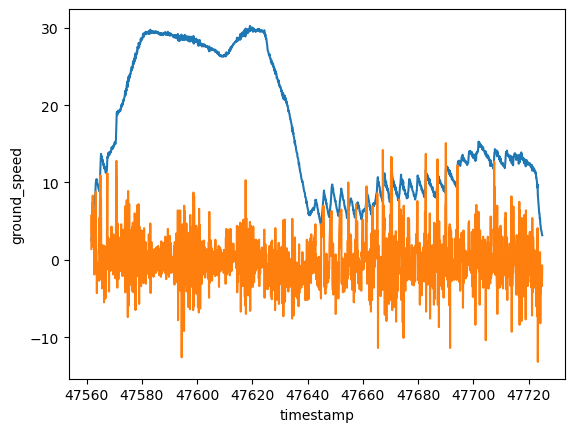

In [82]:
sns.lineplot(r1, x="timestamp", y="ground_speed")
sns.lineplot(r1, x="timestamp", y="acceleration")

In [66]:
#df.to_csv(fn.replace(".ubx", "-lowaccuracy.csv"))
#fig.write_html(fn.replace(".ubx", "-lowaccuracy.html"))